<a href="https://colab.research.google.com/github/AkshayJS/CS6400-Thesis-on-COVID-19-detection-based-on-Chest-X-ray-images/blob/main/QaTa_COV19_ChestXray_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

from PIL import Image

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
drive.mount('/content/gdrive')

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!kaggle datasets download -d aysendegerli/qatacov19-dataset

100% 4.79G/4.79G [01:43<00:00, 40.2MB/s]
100% 4.79G/4.79G [01:43<00:00, 49.9MB/s]


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: QaTa-COV19/QaTa-COV19/Ground-truths/mask_covid_4565.png  
  inflating: QaTa-COV19/QaTa-COV19/Ground-truths/mask_covid_4566.png  
  inflating: QaTa-COV19/QaTa-COV19/Ground-truths/mask_covid_4567.png  
  inflating: QaTa-COV19/QaTa-COV19/Ground-truths/mask_covid_4568.png  
  inflating: QaTa-COV19/QaTa-COV19/Ground-truths/mask_covid_4569.png  
  inflating: QaTa-COV19/QaTa-COV19/Ground-truths/mask_covid_457.png  
  inflating: QaTa-COV19/QaTa-COV19/Ground-truths/mask_covid_4571.png  
  inflating: QaTa-COV19/QaTa-COV19/Ground-truths/mask_covid_4572.png  
  inflating: QaTa-COV19/QaTa-COV19/Ground-truths/mask_covid_4573.png  
  inflating: QaTa-COV19/QaTa-COV19/Ground-truths/mask_covid_4574.png  
  inflating: QaTa-COV19/QaTa-COV19/Ground-truths/mask_covid_4575.png  
  inflating: QaTa-COV19/QaTa-COV19/Ground-truths/mask_covid_4576.png  
  inflating: QaTa-COV19/QaTa-COV19/Ground-truths/mask_covid_4577.png  
  inflating: QaTa-COV19/QaT

In [ ]:
ground_truths_ids = next(os.walk("/content/QaTa-COV19/QaTa-COV19/Ground-truths"))[2] # list of names all images in the given path
print("No. of ground truth images = ", len(ground_truths_ids))

chest_ids = next(os.walk("/content/QaTa-COV19/QaTa-COV19/Images"))[2] # list of names all images in the given path
print("No. of chest images = ", len(chest_ids))

im = Image.open('/content/QaTa-COV19/QaTa-COV19/Ground-truths/'+ground_truths_ids[0])
width, height = im.size
print("Size of Ground truth Image:({},{})".format(width,height))

im = Image.open('/content/QaTa-COV19/QaTa-COV19/Images/'+chest_ids[0])
width, height = im.size
print("Size of chest truth Image:({},{})".format(width,height))

No. of ground truth images =  2951
No. of chest images =  4603
Size of Ground truth Image:(224,224)
Size of chest truth Image:(224,224)


In [ ]:
im_width = 128
im_height = 128
border = 5
X = np.zeros((len(ground_truths_ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ground_truths_ids), im_height, im_width, 1), dtype=np.float32)

In [ ]:
for n, id_ in tqdm_notebook(enumerate(ground_truths_ids), total=len(ground_truths_ids)):
    # Load images
    img = load_img('/content/QaTa-COV19/QaTa-COV19/Images/'+id_[5:], grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img('/content/QaTa-COV19/QaTa-COV19/Ground-truths/'+id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

Text(0.5, 1.0, 'Ground-truth')

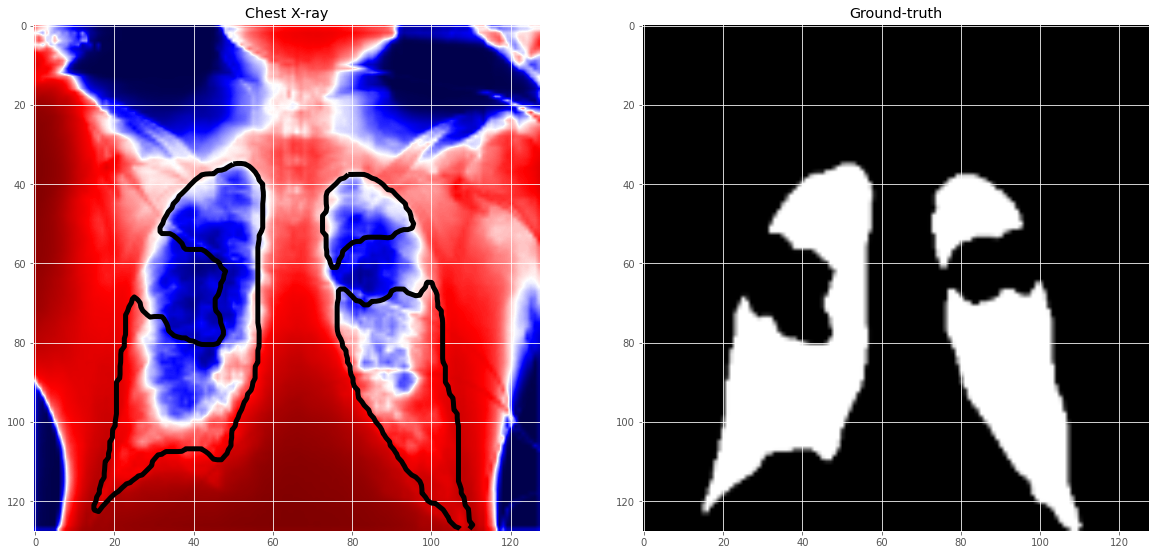

In [ ]:
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Chest X-ray')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Ground-truth')

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'glorot_uniform', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'glorot_uniform', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

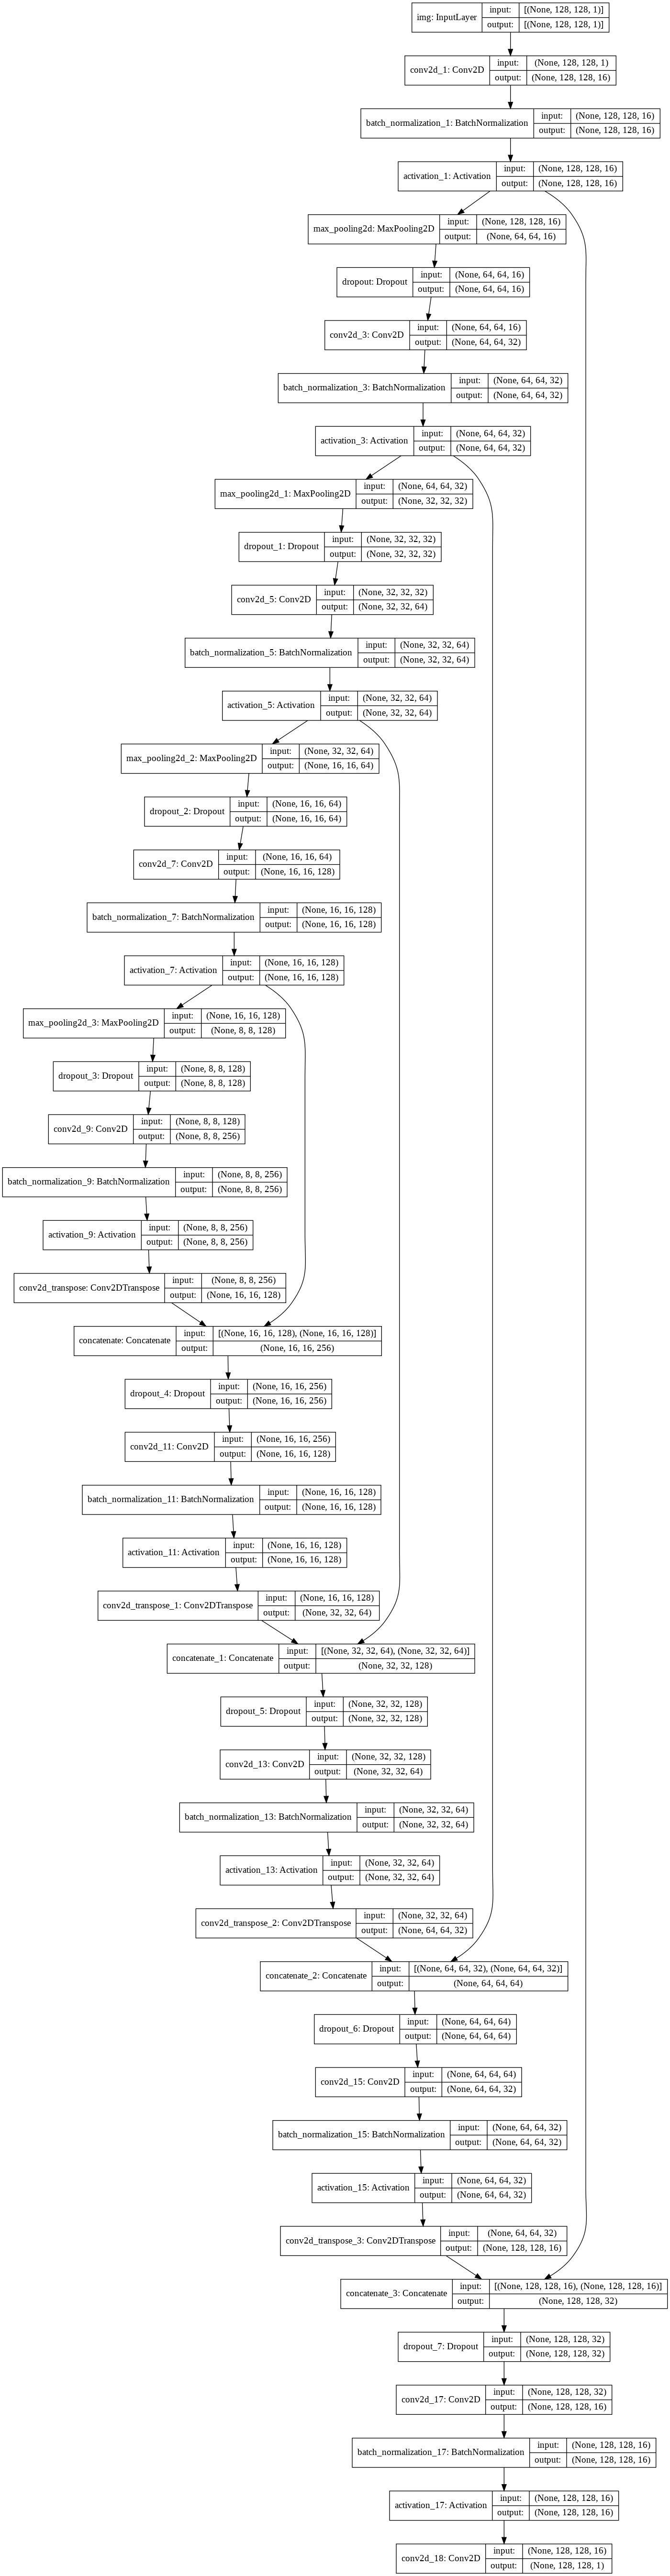

In [ ]:
tf.keras.utils.plot_model(model, "chest-analysis.png", show_shapes=True)

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-covid-19-chest.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:

results = model.fit(X_train, y_train, batch_size=10, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/50
266/266 [==============================] - 71s 68ms/step - loss: 0.3755 - accuracy: 0.8044 - val_loss: 0.3893 - val_accuracy: 0.8127

Epoch 00001: val_loss improved from inf to 0.38929, saving model to model-covid-19-chest.h5
Epoch 2/50
266/266 [==============================] - 16s 59ms/step - loss: 0.1986 - accuracy: 0.8794 - val_loss: 0.3036 - val_accuracy: 0.8269

Epoch 00002: val_loss improved from 0.38929 to 0.30363, saving model to model-covid-19-chest.h5
Epoch 3/50
266/266 [==============================] - 16s 59ms/step - loss: 0.1654 - accuracy: 0.8905 - val_loss: 0.1667 - val_accuracy: 0.8901

Epoch 00003: val_loss improved from 0.30363 to 0.16673, saving model to model-covid-19-chest.h5
Epoch 4/50
266/266 [==============================] - 16s 58ms/step - loss: 0.1523 - accuracy: 0.8958 - val_loss: 0.1717 - val_accuracy: 0.8879

Epoch 00004: val_loss did not improve from 0.16673
Epoch 5/50
266/266 [==============================] - 16s 59ms/step - loss: 0.1533 - 

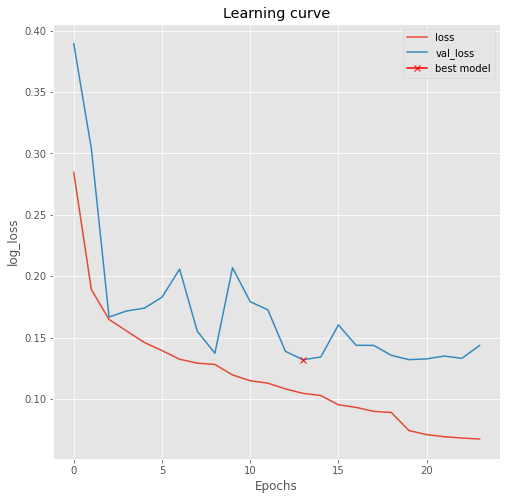

In [ ]:

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
# load the best model
model.load_weights('model-covid-19-chest.h5')

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

10/10 [==============================] - 1s 70ms/step - loss: 0.1320 - accuracy: 0.9026


[0.13197524845600128, 0.9026233553886414]

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

10/10 [==============================] - 0s 41ms/step


In [ ]:

def plot_sample(X, y, preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Chest')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Ground-truth')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Ground-truth Prediction')
    

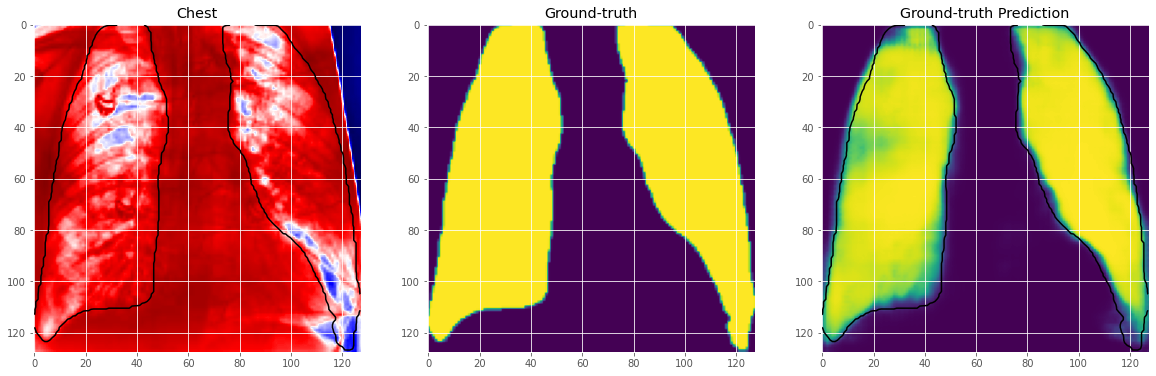

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, ix=14)

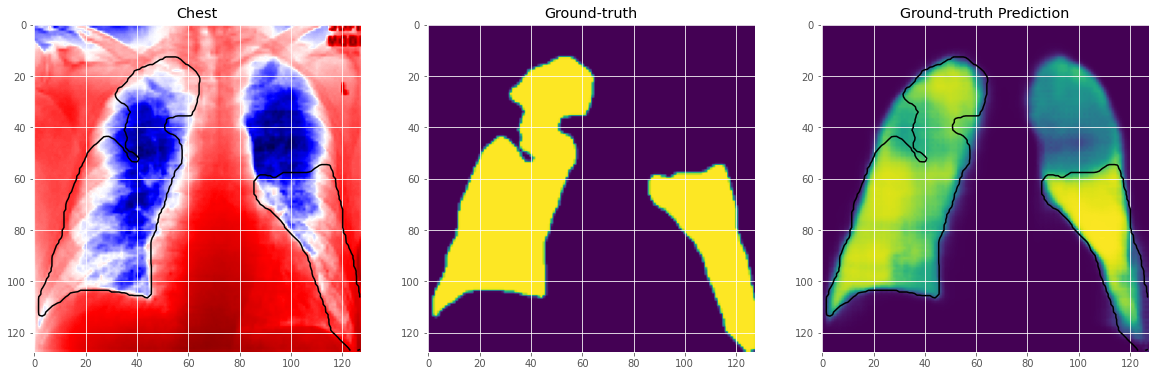

In [ ]:
plot_sample(X_train, y_train, preds_train)

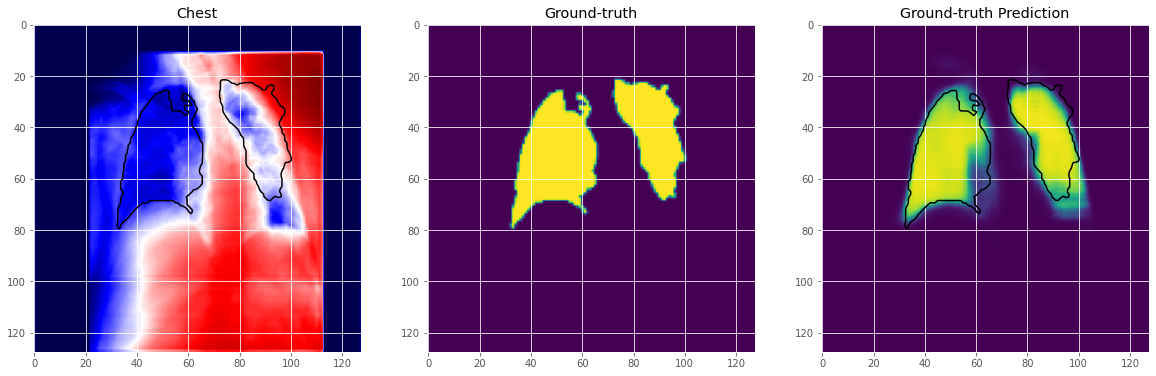

In [ ]:
plot_sample(X_train, y_train, preds_train)

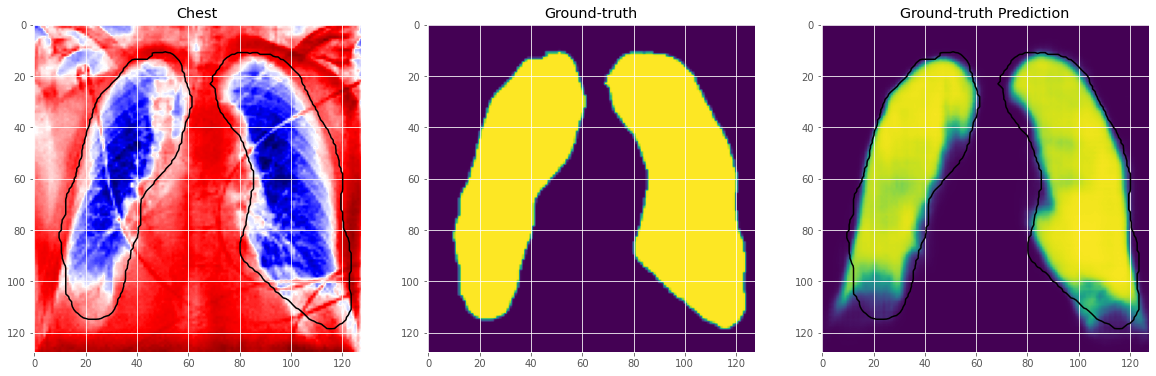

In [ ]:
plot_sample(X_train, y_train, preds_train)

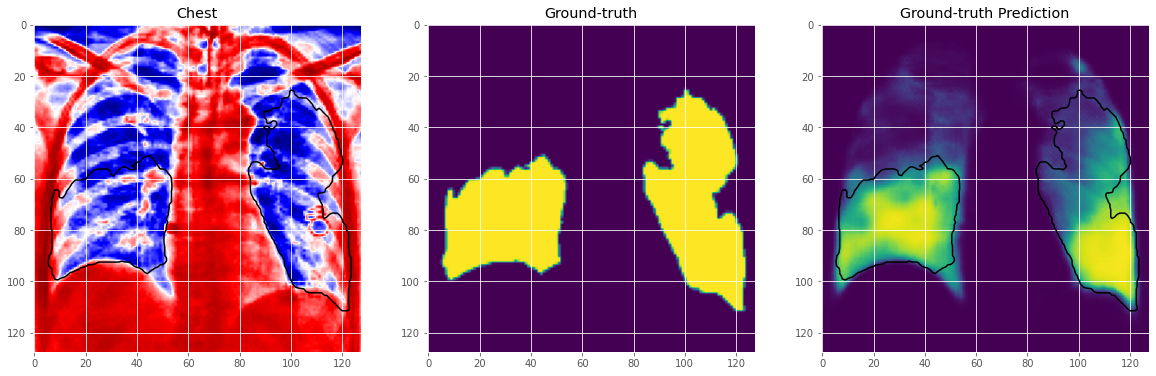

In [ ]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, ix=19)

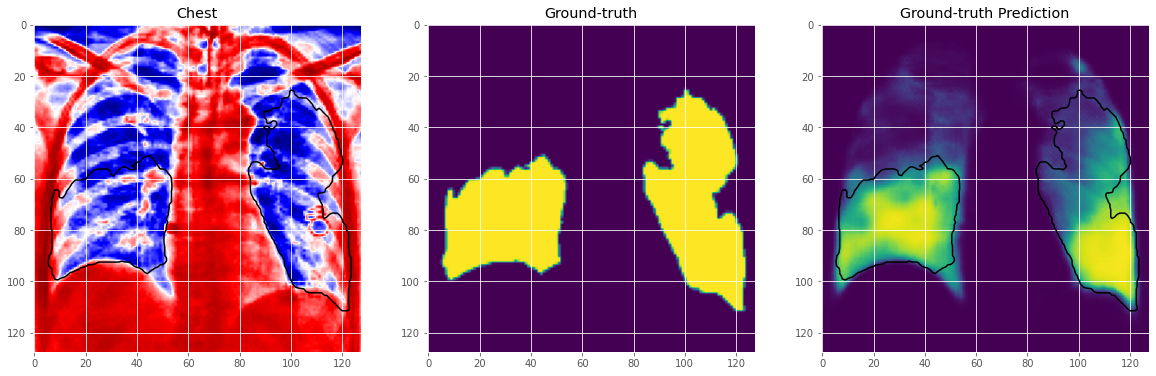

In [ ]:
plot_sample(X_valid, y_valid, preds_val, ix=19)

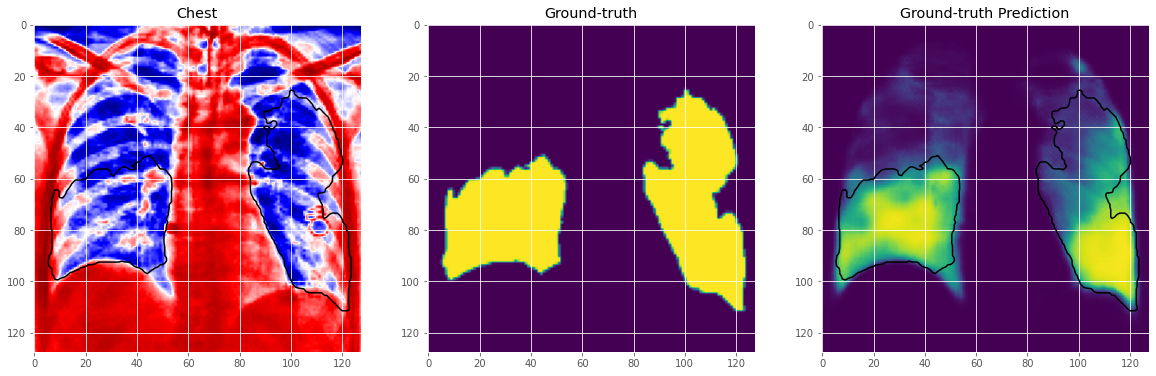

In [ ]:
plot_sample(X_valid, y_valid, preds_val, ix=19)